In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')

In [2]:
from sys import path
path.append('..')
from convexcontrol.main import Controller, ControllerR2
from convexcontrol.resources import PVSys, Battery, TCL, PVSysR2, BatteryR2, DiscreteR2

In [3]:
agg_point = np.zeros(200)
agg_point[:40] = np.linspace(-40, 40, 40)
agg_point[40:60] = np.linspace(40, 0, 20)
agg_point[100:125] = 20.
agg_point[125:130] = 25.
agg_point[130:135] = 30.
agg_point[135:140] = 35.
agg_point[140:145] = 30.
agg_point[145:150] = 25.
agg_point[150:175] = -25.
agg_point[175:200] = -50.

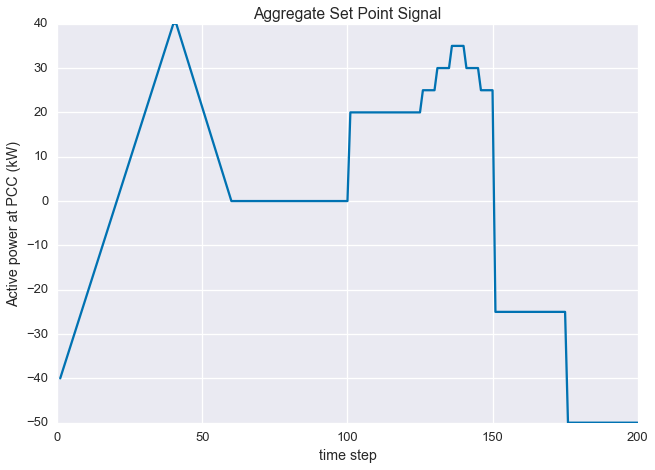

In [4]:
plt.plot(figsize=(14, 8))
plt.plot(range(1, 201), agg_point)
plt.xlabel('time step')
plt.ylabel('Active power at PCC (kW)')
plt.title('Aggregate Set Point Signal')

In [5]:
controller = Controller(mu=1e3)

In [6]:
controller.addResource(PVSys('pv1', T=201))
controller.addResource(PVSys('pv2', T=201, pmax=40))
controller.addResource(Battery('batt1', Cb=1e-1))
controller.addResource(TCL('hvac1', Chvac=1e0))

In [7]:
controller.runSimulation(agg_point, error_diffusion=False, solver='MOSEK')

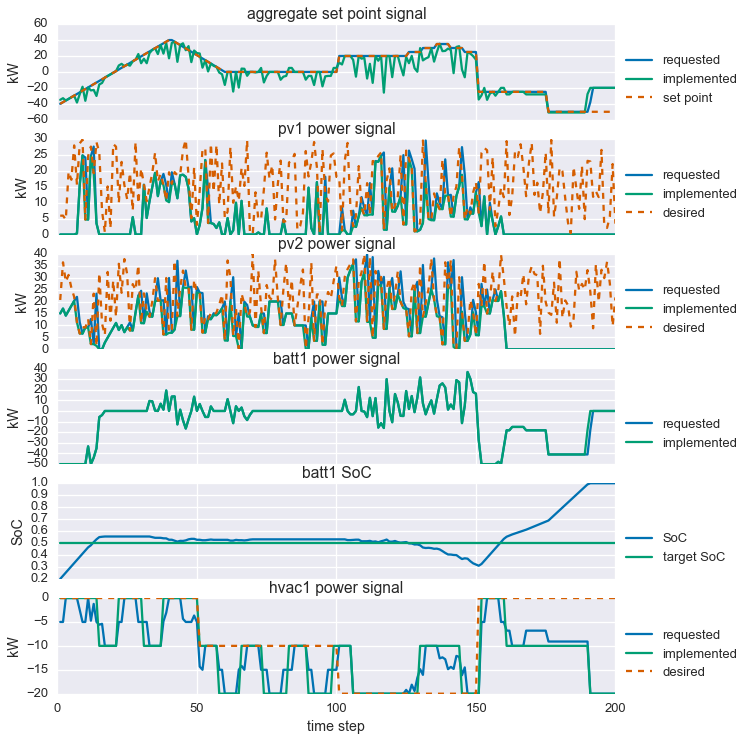

In [8]:
_ = controller.plotReqImpPower()
plt.show()

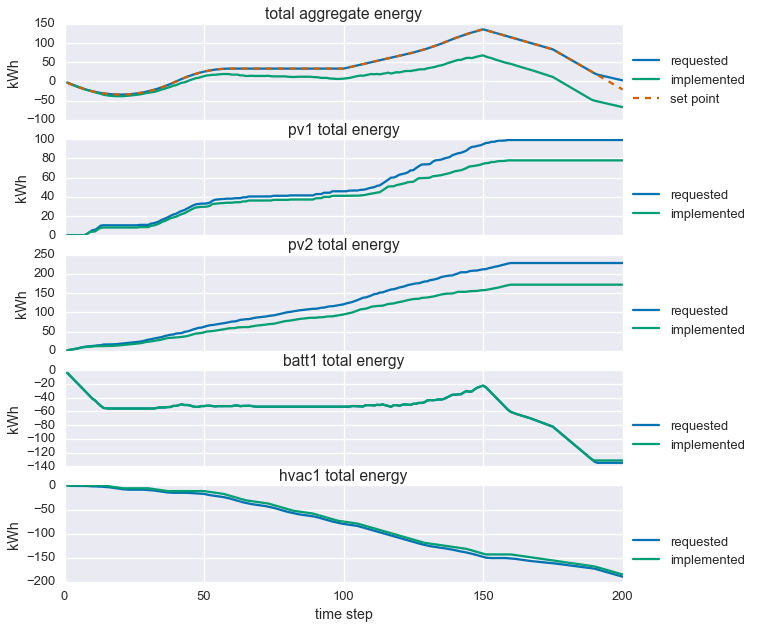

In [9]:
_ = controller.plotReqImpTotalEnergy()
plt.show()

In [10]:
controll_diffuse = Controller(mu=1e3)
controll_diffuse.addResource(PVSys('pv2', T=201))
controll_diffuse.addResource(Battery('batt2', Cb=1e-1))
controll_diffuse.addResource(TCL('hvac2', Chvac=1e0))

In [11]:
controll_diffuse.runSimulation(agg_point, error_diffusion=True, solver='MOSEK')

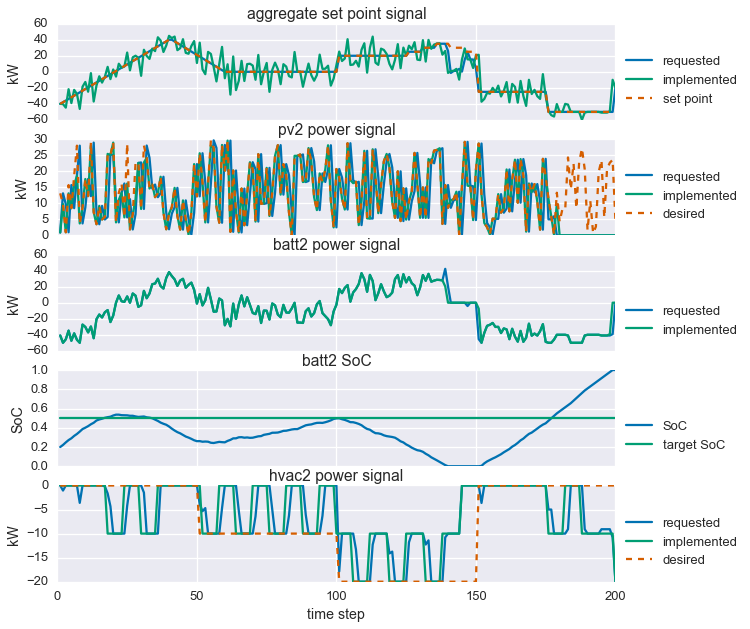

In [12]:
_ = controll_diffuse.plotReqImpPower()

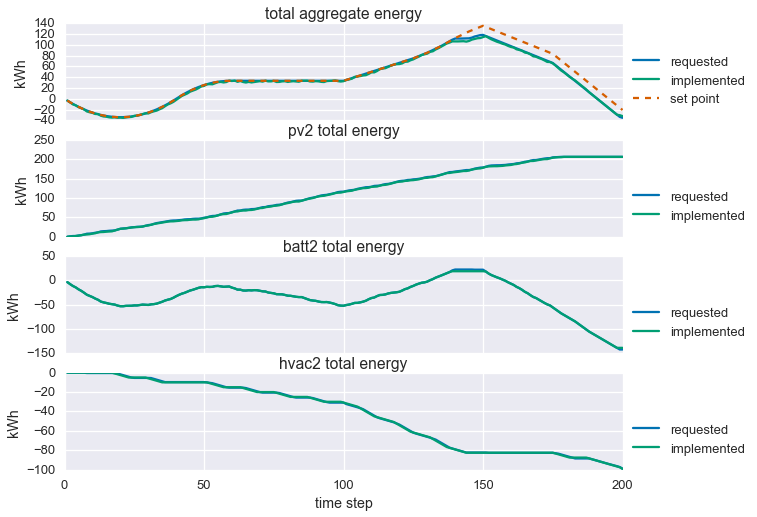

In [13]:
_ = controll_diffuse.plotReqImpTotalEnergy()

In [14]:
# define constants
mu = 10000
agg_point2 = np.concatenate((np.zeros(10),10*np.ones(30),-6*np.arange(10)+10,-50*np.ones(15),15*np.ones(7),np.zeros(8),10*np.ones(20),-10*np.ones(99)))
T = len(agg_point)
agg_point_q = .5*agg_point2
agg_point2 = np.vstack((agg_point2,agg_point_q))
pv1 = PVSysR2('pv1', Cpv=.1)
batt1 = BatteryR2('batt1', initial_SoC=0.5,target_SoC=0.2, Cb=0)
disc1 = DiscreteR2('disc1', points=np.array([[-10,-5], [-20, -10], [-30, -15], [-13, -2], [0, 0]]), Cdisc=0)
contr = ControllerR2(mu=mu)
contr.addResource(pv1)
contr.addResource(batt1)
contr.addResource(disc1)

In [15]:
contr.runSimulation(agg_point2, solver='MOSEK')

In [16]:
contr.resource_list[-2].H

200

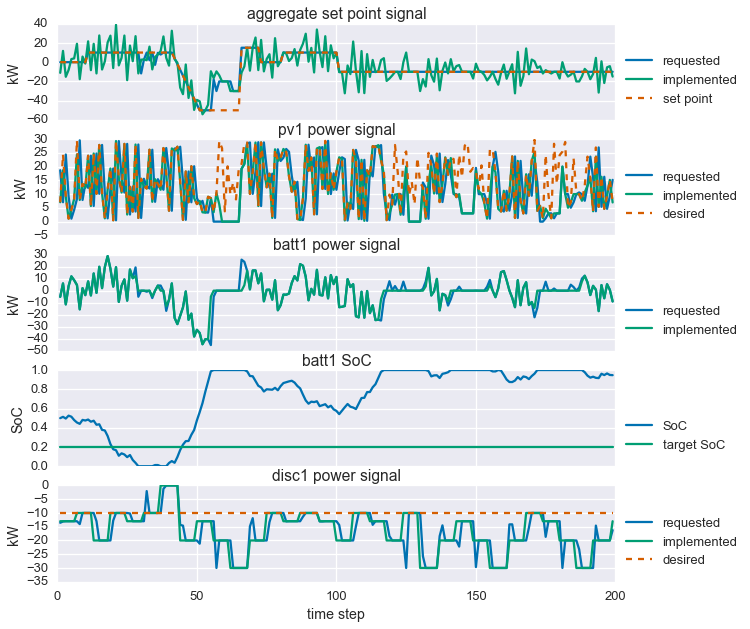

In [17]:
_ = contr.plotReqImpPower('real')

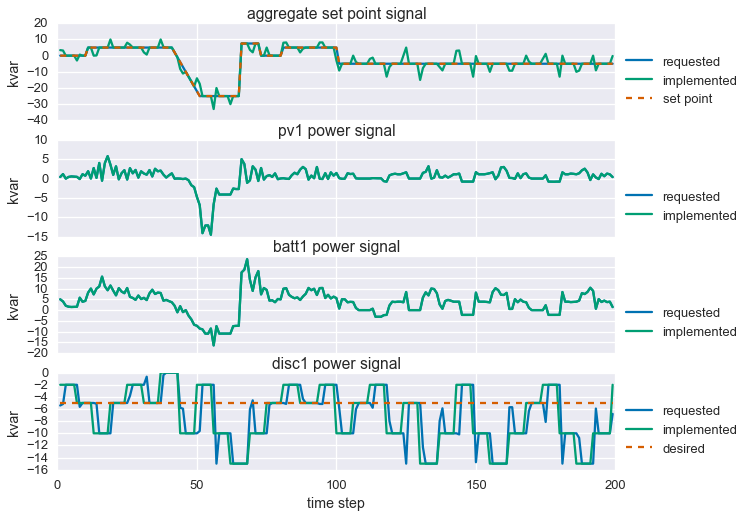

In [18]:
_ = contr.plotReqImpPower('reactive')

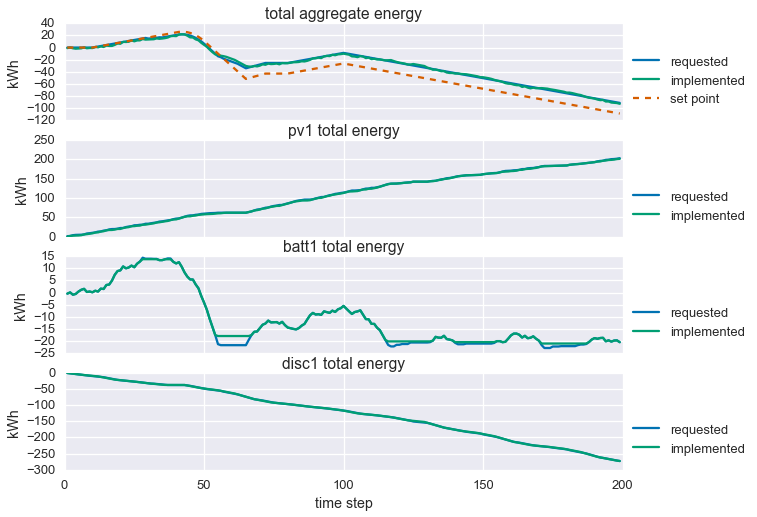

In [19]:
_ = contr.plotReqImpTotalEnergy('real')

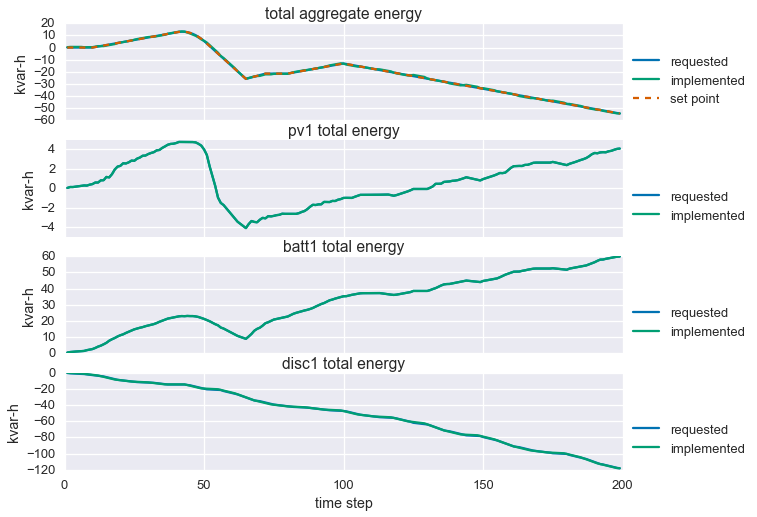

In [20]:
_ = contr.plotReqImpTotalEnergy('reac')